# Ulysses Narrative GMM Turning Points

このノートブックは `scripts/run_report.py` と同等の処理を、Colabで実行する最小版である。


# Ulysses Narrative Turning Points（00: Colab実行＋最小限の統計チェック）

このノートは、scripts/run_report.py と同等の処理を Colab上で再現可能に実行し、
生成された outputs/ を使って **“候補点”の確認（最小限の統計チェック込み）**まで一気に行う「作業用・再現性優先」ノートです。
---

## 重要：このノートの “entropy” は LLM 側の不確実性の探索です
本ノートで扱う entropy は、各spanに対する LLM（分類器）の transition_type 予測確率分布のエントロピーです。
値が高いほど **「どの転調タイプに当てるかをモデルが迷っている」**ことを表します。

※ 別ノートで出てくる **GMM側の entropy（潜在stateの曖昧さ＝boundaryness）**とは別物です。
ここでは「潜在状態の境界」ではなく、「転調タイプ分類の迷い（LLM uncertainty）」をランキング指標として使います。
> 読み方：上から順に「環境構築 → レポート生成 → 出力読み込み → 検定 → 最後に“候補点一覧”を表示」という流れです。

##　このノートで得られるもの（成果物）
outputs/preds_all.csv：各点の cluster / p_max / entropy / margin など（＝LLM出力）

outputs/events_all.csv：各点の transition_type / evidence_ja など（＝アノテーション/イベント）

outputs/top_entropy_points_with_evidence.csv：候補点（LLM entropy 上位）一覧

outputs/transition_type_enrichment_fisher_top_vs_random.csv：Top vs Random の遷移タイプ富化（探索的）

outputs/margin_tests_top_vs_random.csv：Top vs Random の margin 差（探索的）

読み方：上から順に「環境構築 → レポート生成 → 出力読み込み →（必要最小限の）統計チェック → 候補点一覧表示」。

##　統計チェックの位置づけ（最小限・探索）
本ノートの統計チェックは モデル品質の厳密な保証ではなく、
「entropy上位点が、完全にランダム抽出と同じに見えるわけではないか？」をざっくり確認するための 探索的な補助です。
（有意性の主張を目的とせず、所見・備忘録として扱います。）

## 0. セットアップ（迷子防止）
**目的**：Colab上で毎回同じ状態から開始し、実行環境の差によるエラーを潰す。  
**入力/前提**：GitHub repo URL。  
**出力**：`/content/Mokafe-ulysses-narrative-gmm` にclone＋依存導入＋`import narrative_gmm`確認。  
**注意**：ColabはCWDがズレると後続が全部崩れるので、最後に `CWD` を必ず表示する。


In [5]:
# ===== Cell 0: Setup (clone + install + import check) =====
import os, sys, shutil
from pathlib import Path

REPO_URL = "https://github.com/Mokafe/Mokafe-ulysses-narrative-gmm.git"
REPO_DIR = Path("/content/Mokafe-ulysses-narrative-gmm")

# 既存があれば削除してクリーンに（迷い防止）
if REPO_DIR.exists():
    shutil.rmtree(REPO_DIR)

%cd /content
!git clone {REPO_URL}
%cd {REPO_DIR}

# 依存（ログ見えるように -q なし）
!pip install -r requirements.txt

# src を import できるように
sys.path.insert(0, str(Path.cwd() / "src"))

import narrative_gmm
print("OK import narrative_gmm:", narrative_gmm.__file__)
print("CWD:", os.getcwd())
print("TOP:", sorted(os.listdir("."))[:20])


/content
Cloning into 'Mokafe-ulysses-narrative-gmm'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 135 (delta 64), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (135/135), 2.41 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Mokafe-ulysses-narrative-gmm
OK import narrative_gmm: /content/Mokafe-ulysses-narrative-gmm/src/narrative_gmm/__init__.py
CWD: /content/Mokafe-ulysses-narrative-gmm
TOP: ['.git', '00_ulysses_gmm_report_v1_02.ipynb', 'LICENSE', 'README.md', 'data', 'docs', 'notebooks', 'pyproject.toml', 'requirements.txt', 'scripts', 'src']


## レポート生成（GMM→entropy/margin→outputs出力）
**目的**：以降の解析が依存する `outputs/` 一式を生成する（ここが“土台”）。  
**入力/前提**：`data/sample/ulysses_fixed.json` が存在する。  
**出力**：`outputs/preds_all.csv`, `outputs/events_all.csv`, 図PNG, NPZなど。  
**注意**：ここが完走していないと後続セルは必ず失敗する。まずこのセルを通す。


In [6]:
# ===== Cell 1: Run build_report (generate outputs/) =====
from pathlib import Path
from narrative_gmm.report import build_report, ReportConfig

# 入力（repo内にある前提）
INPUT_PATH = "data/sample/ulysses_fixed.json"
assert Path(INPUT_PATH).exists(), f"missing input: {INPUT_PATH}"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cfg = ReportConfig(
    n_components=8,   # そのままでOK（軽くしたいなら 2 でもOK）
    seed=0,
    alpha=0.05,
    top_k=20,
    context_w=3,
    plots=True
)

paths = build_report(INPUT_PATH, str(OUT_DIR), cfg)
print("build_report done. returned paths:\n", paths)


build_report done. returned paths:
 {'events_all': PosixPath('outputs/events_all.csv'), 'preds_all': PosixPath('outputs/preds_all.csv'), 'boundary_topK': PosixPath('outputs/boundary_top20.csv'), 'boundary_context': PosixPath('outputs/boundary_context.csv'), 'scene_turning_density': PosixPath('outputs/scene_turning_density.csv'), 'scene_cluster_transitions': PosixPath('outputs/scene_cluster_transitions.csv'), 'gmm_params': PosixPath('outputs/gmm_params.npz')}


## 出力確認（ファイルが“ある”ことを先に確認）
**目的**：`preds_all.csv` と `events_all.csv` が生成されているかを目視で確かめる。  
**出力**：`outputs/` のファイル一覧。  
**注意**：Assertionで落とすより、まず一覧を見て状況把握したほうが疲労時に強い。


In [7]:
# ===== Cell 2: List outputs =====
from pathlib import Path

OUT_DIR = Path("outputs")
print("outputs exists:", OUT_DIR.exists())
print("outputs files:", sorted([p.name for p in OUT_DIR.glob("*")]))


outputs exists: True
outputs files: ['boundary_context.csv', 'boundary_top20.csv', 'events_all.csv', 'fig_cluster_timeline.png', 'fig_entropy_timeline.png', 'fig_turning_points.png', 'gmm_params.npz', 'preds_all.csv', 'scene_cluster_transitions.csv', 'scene_turning_density.csv']


## Outputs の存在確認（解析前チェック）
後続セルは `outputs/preds_all.csv` と `outputs/events_all.csv` を前提に動くため、まずファイルが生成済みか確認する。  
ここで落ちたら `build_report` が未完走、または作業ディレクトリ（CWD）がズレている可能性が高い。  
OKならこのまま転調点抽出→検定→本文還元へ進む。


In [8]:
# ===== Cell 3: Outputs sanity check =====
from pathlib import Path

OUT_DIR = Path("outputs")
assert (OUT_DIR/"preds_all.csv").exists(), "preds_all.csv がありません（build_report が完走していません）"
assert (OUT_DIR/"events_all.csv").exists(), "events_all.csv がありません（build_report が完走していません）"
print("OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます")


OK: outputs ready -> このまま下の解析セル（転調点/検定/本文還元）へ進めます


## 出力CSVの読み込み（preds / events）
`build_report` が生成した `preds_all.csv`（各点の予測・entropy/margin等）と `events_all.csv`（本文・注釈情報）を読み込む。  
まずファイルの存在を assert で確認し、読み込み後に行列サイズを表示して想定どおり読めているかをチェックする。


In [9]:
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("outputs")
preds_path  = OUT_DIR / "preds_all.csv"
events_path = OUT_DIR / "events_all.csv"

assert preds_path.exists(), f"missing: {preds_path}（上の build_report を先に実行）"
assert events_path.exists(), f"missing: {events_path}（上の build_report を先に実行）"

preds  = pd.read_csv(preds_path)
events = pd.read_csv(events_path)

print("preds:", preds.shape, "events:", events.shape)


preds: (555, 18) events: (555, 14)


## entropy / margin の時系列プロット
`preds` を `global_step` 順に並べ替え、  
不確実性指標の **entropy** と、最上位2クラスタの確率差である **margin** を時間（global_step）に沿って可視化する。  
スパイク（急変）している箇所が「転調点候補」になりやすい。


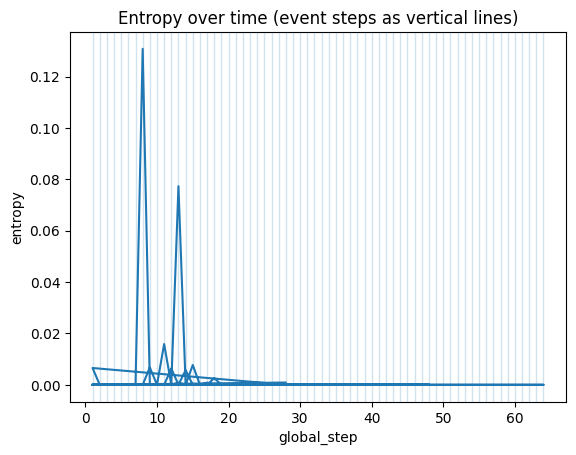

In [10]:
import matplotlib.pyplot as plt
time_col   = "global_step"
entropy_col= "entropy"
margin_col = "margin"

# events がある前提（events_all.csv）
ev_steps = events["global_step"].dropna().unique()

plt.figure()
plt.plot(preds[time_col], preds[entropy_col])
for s in ev_steps:
    plt.axvline(s, linewidth=1, alpha=0.2)
plt.title("Entropy over time (event steps as vertical lines)")
plt.xlabel(time_col); plt.ylabel(entropy_col)
plt.show()


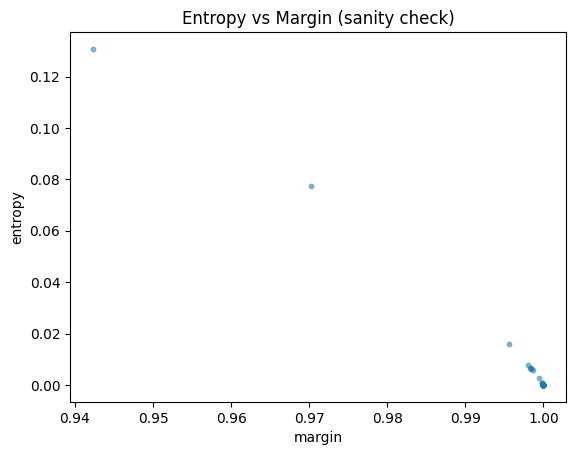

In [11]:
plt.figure()
plt.scatter(preds[margin_col], preds[entropy_col], s=10, alpha=0.5)
plt.title("Entropy vs Margin (sanity check)")
plt.xlabel("margin"); plt.ylabel("entropy")
plt.show()


## 転調点候補（entropy上位K）を本文根拠つきで表示
`events` から evidence 列（日本語優先）を自動検出し、`preds` の entropy 上位K点を抽出する。  
`global_step` で `events` と結合して、各候補点の entropy/margin と evidence を一覧表示する（本文還元の入口）。


In [12]:
from pathlib import Path
import pandas as pd
import numpy as np

OUT_DIR = Path("outputs")
preds_path  = OUT_DIR / "preds_all.csv"
events_path = OUT_DIR / "events_all.csv"

assert preds_path.exists(), f"missing: {preds_path}（上の build_report を先に実行）"
assert events_path.exists(), f"missing: {events_path}（上の build_report を先に実行）"

preds  = pd.read_csv(preds_path)
events = pd.read_csv(events_path)

entropy_col = "entropy"
margin_col = "margin"
KEYS = ["doc_id", "global_step"]

assert all(k in preds.columns for k in KEYS), f"preds missing keys: {KEYS}"
assert all(k in events.columns for k in KEYS), f"events missing keys: {KEYS}"
assert entropy_col in preds.columns, f"preds missing: {entropy_col}"
assert margin_col in preds.columns, f"preds missing: {margin_col}"

assert not preds.duplicated(KEYS).any(), "preds has duplicate (doc_id, global_step)"
assert not events.duplicated(KEYS).any(), "events has duplicate (doc_id, global_step)"

ev_col = None
for c in ["evidence_ja", "evidence", "evidence_en", "quote", "text"]:
    if c in events.columns:
        ev_col = c
        break
print("Detected evidence column:", ev_col)

K = 20
topK = preds.nlargest(K, entropy_col)[KEYS + [entropy_col, margin_col]].copy()

topk_with_evidence = topK.merge(
    events[KEYS + ([ev_col] if ev_col else [])],
    on=KEYS,
    how="left",
    validate="one_to_one",
)

cols = KEYS + [entropy_col, margin_col] + ([ev_col] if ev_col else [])
display(topk_with_evidence[cols])

Detected evidence column: evidence_ja


,doc_id,global_step,entropy,margin,evidence_ja
0,ulysses_ep03_v1,8,0.130792,0.942260,時間を越える言い回しで一般化が起きる。
1,ulysses_ep13_v1,13,0.077312,0.970272,aching / void / heart があり emotion と physio を高めた。
2,ulysses_ep04_v1,11,0.015857,0.995535,「eyelids」「warmth」で身体感覚＋「breadvan」で外界入力へ。
3,ulysses_ep13_v1,15,0.007699,0.998060,反復と感嘆符があり emotion と syntax_break を上げた。
4,ulysses_ep05_v1,9,0.006730,0.998337,具体動作（took/unfolded/rolled）が連続する。
5,ulysses_ep03_v1,1,0.006532,0.998392,視覚入力を「思考」として扱う表現がある。
6,ulysses_ep12_v1,12,0.006317,0.998452,turned into で移動、corner で位置が定まる。
7,ulysses_ep01_v1,14,0.005689,0.998626,焦点語「offence」「me」で自己へ収束。
8,ulysses_ep04_v1,18,0.002590,0.999435,「horror」「seared」で情動、「hurrying homeward」で行為に切替。
9,ulysses_ep06_v1,28,0.000879,0.999831,礼の語と評価語で内言の情動が出る。


## 転調点候補の前後文脈（±wイベント）を表示
entropy上位10点について、該当 `global_step` の前後 ±w（ここでは3）イベントを取り出し、evidence を並べて表示する。  
単発の点ではなく「前後の流れ」として確認することで、転調がどのような文脈で起きたかを精読しやすくする。


In [16]:
w = 3
KEYS = ["doc_id", "global_step"]

events_sorted = events.sort_values(KEYS).reset_index(drop=True)

def context_window(doc_id, step, w=3):
    g = events_sorted[events_sorted["doc_id"] == doc_id].reset_index(drop=True)
    hit = g.index[g["global_step"] == step].tolist()
    if not hit:
        return None
    i = hit[0]
    lo = max(0, i - w)
    hi = min(len(g), i + w + 1)
    return g.iloc[lo:hi].copy()

top10 = preds.nlargest(10, entropy_col)[KEYS + [entropy_col, margin_col]].copy()

for _, r in top10.iterrows():
    doc_id = r["doc_id"]
    step = r["global_step"]
    print("\n" + "=" * 80)
    print(f"doc_id={doc_id} | global_step={step} | entropy={float(r[entropy_col]):.6g} | margin={float(r[margin_col]):.6g}")

    ctx = context_window(doc_id, step, w=w)
    if ctx is None:
        print("context not found")
        continue

    show = KEYS + ([ev_col] if ev_col else [])
    display(ctx[show])



doc_id=ulysses_ep03_v1 | global_step=8 | entropy=0.130792 | margin=0.94226


,doc_id,global_step,evidence_ja
4,ulysses_ep03_v1,5,拒否と驚愕語が出て、転落想像が始まる。
5,ulysses_ep03_v1,6,連続擬音で音中心の知覚が強い。
6,ulysses_ep03_v1,7,韻律用語で構造を数える方向へ向く。
7,ulysses_ep03_v1,8,時間を越える言い回しで一般化が起きる。
8,ulysses_ep03_v1,9,第三者の動作描写が中心になる。
9,ulysses_ep03_v1,10,問いかけで内容推定が始まっている。
10,ulysses_ep03_v1,11,固有語・呼びかけ・転送命令が連続する。



doc_id=ulysses_ep13_v1 | global_step=13 | entropy=0.0773125 | margin=0.970272


,doc_id,global_step,evidence_ja
9,ulysses_ep13_v1,10,疑問形が推論・言語処理を促すため reasoning/linguistic を上げた。
10,ulysses_ep13_v1,11,seated と lost in thought が同居し perception と inn...
11,ulysses_ep13_v1,12,prompted / told / silent により内的制御の reasoning と ...
12,ulysses_ep13_v1,13,aching / void / heart があり emotion と physio を高めた。
13,ulysses_ep13_v1,14,dressed / taste / Fashion により perception と goa...
14,ulysses_ep13_v1,15,反復と感嘆符があり emotion と syntax_break を上げた。
15,ulysses_ep13_v1,16,sound / voices / organ により sensory 優勢、教会文脈で in...



doc_id=ulysses_ep04_v1 | global_step=11 | entropy=0.0158574 | margin=0.995535


,doc_id,global_step,evidence_ja
7,ulysses_ep04_v1,8,移動語（went up / staircase / hall）で場面が切り替わる。
8,ulysses_ep04_v1,9,会話マーカー（—）で発話モードに入る。
9,ulysses_ep04_v1,10,短文断片＋命令形（Must get it）が連続。
10,ulysses_ep04_v1,11,「eyelids」「warmth」で身体感覚＋「breadvan」で外界入力へ。
11,ulysses_ep04_v1,12,「Somewhere in the east」「Travel」で場所・行為が空想に移行。
12,ulysses_ep04_v1,13,会話マーカー（—）＋固有名で対人場面に切替。
13,ulysses_ep04_v1,14,「halted」「staring」で視覚への集中が明示。



doc_id=ulysses_ep13_v1 | global_step=15 | entropy=0.00769867 | margin=0.99806


,doc_id,global_step,evidence_ja
11,ulysses_ep13_v1,12,prompted / told / silent により内的制御の reasoning と ...
12,ulysses_ep13_v1,13,aching / void / heart があり emotion と physio を高めた。
13,ulysses_ep13_v1,14,dressed / taste / Fashion により perception と goa...
14,ulysses_ep13_v1,15,反復と感嘆符があり emotion と syntax_break を上げた。
15,ulysses_ep13_v1,16,sound / voices / organ により sensory 優勢、教会文脈で in...
16,ulysses_ep13_v1,17,hearths / homes と ruined があり memory/emotion_dr...
17,ulysses_ep13_v1,18,rolled / stopped / under が運動・位置の感覚情報で sensory ...



doc_id=ulysses_ep05_v1 | global_step=9 | entropy=0.00672986 | margin=0.998337


,doc_id,global_step,evidence_ja
5,ulysses_ep05_v1,6,動作（put on）と印字語（choice blend）が連結する。
6,ulysses_ep05_v1,7,評価断片（Lovely spot）と比喩的列挙（leaves to float）が続く。
7,ulysses_ep05_v1,8,「law」から人名・授業描写（High school... teaching）へ移る。
8,ulysses_ep05_v1,9,具体動作（took/unfolded/rolled）が連続する。
9,ulysses_ep05_v1,10,会話マーカー（—）と質問文が明示される。
10,ulysses_ep05_v1,11,「gazed」「nostrils」で視覚＋嗅覚の切替が表れる。
11,ulysses_ep05_v1,12,受け取り（handed back）と応答（thanked）が連続。



doc_id=ulysses_ep03_v1 | global_step=1 | entropy=0.00653156 | margin=0.998392


,doc_id,global_step,evidence_ja
0,ulysses_ep03_v1,1,視覚入力を「思考」として扱う表現がある。
1,ulysses_ep03_v1,2,命令形で知覚（目）を操作している。
2,ulysses_ep03_v1,3,視覚遮断→聴覚への切替が明示される。
3,ulysses_ep03_v1,4,時間と空間の語で抽象的に扱っている。



doc_id=ulysses_ep12_v1 | global_step=12 | entropy=0.00631733 | margin=0.998452


,doc_id,global_step,evidence_ja
8,ulysses_ep12_v1,9,修辞的な反復で文体が変化。
9,ulysses_ep12_v1,10,名詞列挙と形容で叙述が肥大化。
10,ulysses_ep12_v1,11,短い反復で攻撃的な発話が前面化。
11,ulysses_ep12_v1,12,turned into で移動、corner で位置が定まる。
12,ulysses_ep12_v1,13,形容語の連結で修辞密度が急増。
13,ulysses_ep12_v1,14,hung a row / jangled が物理描写を押し出す。
14,ulysses_ep12_v1,15,sight/eyes が感覚中心で、驚きが示される。



doc_id=ulysses_ep01_v1 | global_step=14 | entropy=0.00568896 | margin=0.998626


,doc_id,global_step,evidence_ja
10,ulysses_ep01_v1,11,「symbol」「cracked lookingglass」で概念化/言語化。
11,ulysses_ep01_v1,12,「remember」「after my mother’s death」で回想アンカー。
12,ulysses_ep01_v1,13,引用符的再現（過去発話の再掲）。
13,ulysses_ep01_v1,14,焦点語「offence」「me」で自己へ収束。
14,ulysses_ep01_v1,15,雲/太陽の知覚変化で外界へ。
15,ulysses_ep01_v1,16,ラテン語句の連鎖で引用/間テキスト密度が高い。
16,ulysses_ep01_v1,17,感嘆・命令/懇願の連続で情動主導。



doc_id=ulysses_ep04_v1 | global_step=18 | entropy=0.00258982 | margin=0.999435


,doc_id,global_step,evidence_ja
14,ulysses_ep04_v1,15,「took a page」「model farm」で紙面テキストへの移行。
15,ulysses_ep04_v1,16,「cloud」「cover the sun」で視覚環境の変化。
16,ulysses_ep04_v1,17,"「No, not like that」で反転し、「dead sea」で想像場面が立ち上がる。"
17,ulysses_ep04_v1,18,「horror」「seared」で情動、「hurrying homeward」で行為に切替。
18,ulysses_ep04_v1,19,「letters」「card」→「Mrs Marion Bloom」で対象が確定。
19,ulysses_ep04_v1,20,会話マーカー＋要求（parched）→応答（kettle is boiling）。
20,ulysses_ep04_v1,21,未知語の提示（Metempsychosis）と即時の追問が起こる。



doc_id=ulysses_ep06_v1 | global_step=28 | entropy=0.000878985 | margin=0.999831


,doc_id,global_step,evidence_ja
24,ulysses_ep06_v1,25,Now who is... の反復で注意対象が急に変わる。
25,ulysses_ep06_v1,26,if + alive の仮定と感嘆で情動駆動の想像が突出。
26,ulysses_ep06_v1,27,具体的対象（rat）と運動描写で感覚入力が主。
27,ulysses_ep06_v1,28,礼の語と評価語で内言の情動が出る。


In [17]:
merged_out = OUT_DIR / "turning_topK_with_evidence.csv"
topk_with_evidence.to_csv(merged_out, index=False, encoding="utf-8-sig")
print("Saved:", merged_out)


Saved: outputs/turning_topK_with_evidence.csv


## 効果量（Cliff’s delta）で「実質差」を確認
Top群とRandom群の margin について、分布の差を **効果量** Cliff’s delta で評価する。  
Cliff’s delta は「TopがRandomより大きい確率 − 小さい確率」で、0に近ければ差が小さく、±1に近いほど分離が強い。  
あわせて両群の中央値も表示し、差の方向と大きさを要約する。


In [19]:
print("SKIP: m_top / m_rnd は旧 Top-vs-Random 解析の変数です。現行版では未使用。")

SKIP: m_top / m_rnd は旧 Top-vs-Random 解析の変数です。現行版では未使用。


## 遷移タイプの富化検定（探索的チェック）
entropy 上位（Top）と、残りから同サイズをランダム抽出した集合（Random）を作り、各 transition_type の出現率差を 2×2 表で比較する。Fisher 正確確率検定（odds ratio / p）も併記するが、本セルは 仮説生成を目的とする探索であり、多重比較・サンプル選択（seed）・系列依存の影響があるため、p値の確証的解釈は行わない。再現性のため、抽出条件（K/seed）と集計表を保存する。



In [20]:
# ===== Add-on (1 cell): transition_type enrichment + seed sweep + BH-FDR (safe) =====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact
from IPython.display import display  # Notebookでdisplayを安全に使う

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: 精度重視（doc_id + global_step を最優先）
# ------------------------------------------------------------
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],      # 最優先（エピソード内連番の衝突を回避）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],                # 最後手段（潰れうる）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds cols head={list(preds.columns)[:30]}\n"
        f"events cols head={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge（_x/_y回避 + 重複で増減しないように）
# ------------------------------------------------------------
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2_raw = preds.drop(columns=drop_like, errors="ignore")
events2_raw = events.copy()

before_preds = len(preds2_raw)
before_events = len(events2_raw)

preds2  = preds2_raw.drop_duplicates(subset=merge_keys, keep="first")
events2 = events2_raw.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates({merge_keys})")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates({merge_keys})")

# 激減していたら警告（続行はするが、解釈注意）
if len(preds2) < before_preds * 0.8 or len(events2) < before_events * 0.8:
    print("⚠ WARNING: rows dropped a lot. merge_keys may be too weak:", merge_keys)

df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

for col in ["entropy", "margin", "transition_type"]:
    assert col in df.columns, f"{col} missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

# ------------------------------------------------------------
# 2) パラメータ
# ------------------------------------------------------------
TOPN  = 150
RANDN = 150
SEED_LIST = list(range(0, 30))
REP_SEED = 0

# ------------------------------------------------------------
# 3) BH-FDR（Benjamini-Hochberg）
# ------------------------------------------------------------
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    if m == 0:
        return pvals
    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(m, dtype=float)
    prev = 1.0
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * m / rank
        prev = min(prev, val)
        q[i] = prev
    out = np.empty(m, dtype=float)
    out[order] = np.clip(q, 0.0, 1.0)
    return out

# ------------------------------------------------------------
# 4) 1回の Top/Random から enrichment
# ------------------------------------------------------------
def enrichment_once(df_in: pd.DataFrame, topn: int, randn: int, seed: int) -> pd.DataFrame:
    df_sorted = df_in.sort_values("entropy", ascending=False).reset_index(drop=True)
    top = df_sorted.head(topn).copy()
    remain = df_sorted.iloc[topn:].copy()
    if len(remain) < randn:
        raise ValueError(f"Not enough remaining rows for RANDN={randn}. remain={len(remain)}")
    rnd = remain.sample(n=randn, random_state=seed).copy()

    types = sorted(pd.concat([top["transition_type"], rnd["transition_type"]], ignore_index=True).unique().tolist())

    rows = []
    for t in types:
        top_has = int((top["transition_type"] == t).sum())
        rnd_has = int((rnd["transition_type"] == t).sum())
        top_no  = int(len(top) - top_has)
        rnd_no  = int(len(rnd) - rnd_has)

        odds, p = fisher_exact([[top_has, top_no], [rnd_has, rnd_no]], alternative="two-sided")

        top_rate = top_has / len(top)
        rnd_rate = rnd_has / len(rnd)
        diff = top_rate - rnd_rate

        rows.append({
            "transition_type": t,
            "top_count": top_has,
            "rnd_count": rnd_has,
            "top_rate": top_rate,
            "rnd_rate": rnd_rate,
            "diff_rate_top_minus_rnd": diff,
            "odds_ratio": (float(odds) if np.isfinite(odds) else np.inf),
            "p_fisher_two_sided": float(p),
        })

    out = pd.DataFrame(rows)
    # ★qは「このseedのこの表の中」でのみ意味があるので、rep用に使う程度に留める
    out["q_bh_fdr_seedlocal"] = bh_fdr(out["p_fisher_two_sided"].to_numpy())
    return out

# ------------------------------------------------------------
# 5) seed sweep（恣意性排除：方向とpの安定性を見る）
# ------------------------------------------------------------
all_runs = []
for seed in SEED_LIST:
    enr = enrichment_once(df, TOPN, RANDN, seed)
    enr["seed"] = seed
    all_runs.append(enr)

all_df = pd.concat(all_runs, ignore_index=True)

# 要約：qは集約せず、diffとpの安定性中心
summary = (
    all_df
    .groupby("transition_type", as_index=False)
    .agg(
        n_runs=("seed", "count"),
        diff_median=("diff_rate_top_minus_rnd", "median"),
        diff_mean=("diff_rate_top_minus_rnd", "mean"),
        pos_rate=("diff_rate_top_minus_rnd", lambda x: float((x > 0).mean())),
        neg_rate=("diff_rate_top_minus_rnd", lambda x: float((x < 0).mean())),
        p_median=("p_fisher_two_sided", "median"),
        p_min=("p_fisher_two_sided", "min"),
        sig_rate_p05=("p_fisher_two_sided", lambda x: float((x < 0.05).mean())),
    )
)

# 「median p」に対して1回だけBH（←報告向けのq）
summary["q_bh_from_median_p"] = bh_fdr(summary["p_median"].to_numpy())

summary = summary.sort_values(
    ["q_bh_from_median_p", "p_median", "diff_median"],
    ascending=[True, True, False]
).reset_index(drop=True)

print(f"\n=== Seed sweep summary (TOPN={TOPN}, RANDN={RANDN}, runs={len(SEED_LIST)}) ===")
display(summary)

# ------------------------------------------------------------
# 6) 代表seed（REP_SEED）の詳細表（これが“表として貼りやすい”）
# ------------------------------------------------------------
rep = all_df[all_df["seed"] == REP_SEED].drop(columns=["seed"]).copy()
rep = rep.sort_values(
    ["q_bh_fdr_seedlocal", "p_fisher_two_sided", "diff_rate_top_minus_rnd"],
    ascending=[True, True, False]
).reset_index(drop=True)

print(f"\n=== Enrichment table (representative seed={REP_SEED}) ===")
display(rep)

# ------------------------------------------------------------
# 7) 保存
# ------------------------------------------------------------
summary_path = OUT_DIR / f"transition_type_enrichment_seed_sweep_summary_TOP{TOPN}_RAND{RANDN}.csv"
all_path     = OUT_DIR / f"transition_type_enrichment_seed_sweep_allruns_TOP{TOPN}_RAND{RANDN}.csv"
rep_path     = OUT_DIR / f"transition_type_enrichment_seed{REP_SEED}_TOP{TOPN}_RAND{RANDN}.csv"

summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
all_df.to_csv(all_path, index=False, encoding="utf-8-sig")
rep.to_csv(rep_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", summary_path)
print(" -", all_path)
print(" -", rep_path)


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates(['doc_id', 'global_step'])
events: 555 -> 555 after drop_duplicates(['doc_id', 'global_step'])
merged df rows: 555

=== Seed sweep summary (TOPN=150, RANDN=150, runs=30) ===


,transition_type,n_runs,diff_median,diff_mean,pos_rate,neg_rate,p_median,p_min,sig_rate_p05,q_bh_from_median_p
0,script_switch,30,-0.093333,-0.093778,0.000000,1.000000,0.043255,0.001263,0.533333,0.389296
1,contrast,30,0.040000,0.043333,1.000000,0.000000,0.321109,0.053502,0.000000,0.954180
2,semantic_association,30,0.026667,0.029556,0.933333,0.033333,0.610825,0.100072,0.000000,0.954180
3,self_censor,30,0.013333,0.010889,0.833333,0.000000,0.622479,0.247492,0.000000,0.954180
4,rumination,30,-0.013333,-0.009778,0.266667,0.666667,0.645565,0.134930,0.000000,0.954180
5,completion,30,0.016667,0.016000,0.766667,0.200000,0.751019,0.178224,0.000000,0.954180
6,phonetic_association,30,-0.006667,-0.005556,0.266667,0.633333,0.769770,0.197668,0.000000,0.954180
7,intrusion,30,0.013333,0.012000,0.633333,0.333333,0.848160,0.186039,0.000000,0.954180
8,goal_task,12,-0.006667,-0.006667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000



=== Enrichment table (representative seed=0) ===


,transition_type,top_count,rnd_count,top_rate,rnd_rate,diff_rate_top_minus_rnd,odds_ratio,p_fisher_two_sided,q_bh_fdr_seedlocal
0,script_switch,18,32,0.120000,0.213333,-0.093333,0.502841,0.043255,0.346041
1,contrast,17,10,0.113333,0.066667,0.046667,1.789474,0.225609,0.778820
2,semantic_association,22,15,0.146667,0.100000,0.046667,1.546875,0.292058,0.778820
3,rumination,16,20,0.106667,0.133333,-0.026667,0.776119,0.594539,0.969342
4,intrusion,44,39,0.293333,0.260000,0.033333,1.181422,0.605839,0.969342
5,completion,25,27,0.166667,0.180000,-0.013333,0.911111,0.878910,1.000000
6,phonetic_association,5,4,0.033333,0.026667,0.006667,1.258621,1.000000,1.000000
7,self_censor,3,3,0.020000,0.020000,0.000000,1.000000,1.000000,1.000000



Saved:
 - outputs/transition_type_enrichment_seed_sweep_summary_TOP150_RAND150.csv
 - outputs/transition_type_enrichment_seed_sweep_allruns_TOP150_RAND150.csv
 - outputs/transition_type_enrichment_seed0_TOP150_RAND150.csv


メモ：「script_switch は高不確実性地点では相対的に出にくい傾向（方向は安定）。他は弱い／不安定。
ただし、「探索メモであり、一般化は意図しない。」

In [21]:
# ===== Add-on (1 cell): transition_type enrichment (Top vs Rest / Fisher) + BH-FDR =====
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import fisher_exact

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR / "preds_all.csv")
events = pd.read_csv(OUT_DIR / "events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: 明示固定（安全優先）
# ------------------------------------------------------------
merge_keys = ["doc_id", "global_step"]

for k in merge_keys:
    assert k in preds.columns, f"preds missing key: {k}"
    assert k in events.columns, f"events missing key: {k}"

print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge前の安全確認
# ------------------------------------------------------------
before_preds = len(preds)
before_events = len(events)

drop_like = [
    c for c in preds.columns
    if c.startswith(("evidence", "span_text", "transition_type"))
]

preds2 = (
    preds
    .drop(columns=drop_like, errors="ignore")
    .drop_duplicates(subset=merge_keys, keep="first")
)

events2 = (
    events
    .drop_duplicates(subset=merge_keys, keep="first")
)

if len(preds2) != before_preds:
    raise RuntimeError(f"preds collapsed: {before_preds} -> {len(preds2)}")
if len(events2) != before_events:
    raise RuntimeError(f"events collapsed: {before_events} -> {len(events2)}")

df = preds2.merge(
    events2,
    on=merge_keys,
    how="left",
    validate="one_to_one",
)

# 必須列チェック
for col in ["entropy", "transition_type"]:
    assert col in df.columns, f"{col} missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

print("preds:", len(preds), "->", len(preds2), "after drop_duplicates", merge_keys)
print("events:", len(events), "->", len(events2), "after drop_duplicates", merge_keys)
print("merged df rows:", len(df))

# ------------------------------------------------------------
# 2) パラメータ（TopNのみ指定。Restは残り全部）
# ------------------------------------------------------------
TOPN = 150   # 必要に応じて 80 / 150 / 200 などに変更

df_sorted = df.sort_values("entropy", ascending=False).reset_index(drop=True)
top  = df_sorted.head(TOPN).copy()
rest = df_sorted.iloc[TOPN:].copy()

if len(rest) == 0:
    raise ValueError(f"Restが0件です。TOPN={TOPN} を小さくしてください。")

top["group"]  = "top"
rest["group"] = "rest"

print(f"Top n={len(top)} | Rest n={len(rest)} | Total n={len(df_sorted)}")

# ------------------------------------------------------------
# 3) BH-FDR（Benjamini-Hochberg）
# ------------------------------------------------------------
def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    pvals = np.asarray(pvals, dtype=float)
    m = len(pvals)
    if m == 0:
        return pvals

    order = np.argsort(pvals)
    ranked = pvals[order]
    q = np.empty(m, dtype=float)

    prev = 1.0
    for i in range(m - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * m / rank
        prev = min(prev, val)
        q[i] = prev

    out = np.empty(m, dtype=float)
    out[order] = np.clip(q, 0.0, 1.0)
    return out

# ------------------------------------------------------------
# 4) transition_type enrichment（2×2 per type; Top vs Rest）
# ------------------------------------------------------------
types = sorted(
    pd.concat([top["transition_type"], rest["transition_type"]], ignore_index=True)
      .unique()
      .tolist()
)

rows = []
for t in types:
    top_has  = int((top["transition_type"]  == t).sum())
    rest_has = int((rest["transition_type"] == t).sum())
    top_no   = int(len(top)  - top_has)
    rest_no  = int(len(rest) - rest_has)

    odds, p = fisher_exact(
        [[top_has, top_no], [rest_has, rest_no]],
        alternative="two-sided"
    )

    top_rate  = top_has / len(top)
    rest_rate = rest_has / len(rest)
    diff = top_rate - rest_rate

    rows.append({
        "transition_type": t,
        "top_count": top_has,
        "rest_count": rest_has,
        "top_rate": top_rate,
        "rest_rate": rest_rate,
        "diff_rate_top_minus_rest": diff,
        "odds_ratio": (float(odds) if np.isfinite(odds) else np.inf),
        "p_fisher_two_sided": float(p),
    })

enr = pd.DataFrame(rows)
enr["q_bh_fdr"] = bh_fdr(enr["p_fisher_two_sided"].to_numpy())

enr = enr.sort_values(
    ["q_bh_fdr", "p_fisher_two_sided", "diff_rate_top_minus_rest"],
    ascending=[True, True, False]
).reset_index(drop=True)

print("\n=== transition_type enrichment (Top vs Rest; Fisher 2×2 per type) ===")
display(enr)

# ------------------------------------------------------------
# 5) 保存
# ------------------------------------------------------------
out_csv = OUT_DIR / f"transition_type_enrichment_fisher_top_vs_rest_TOP{TOPN}.csv"
enr.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("\nSaved:", out_csv)

keep_cols = [c for c in (merge_keys + ["entropy", "transition_type"]) if c in df_sorted.columns]
both_out = pd.concat(
    [top[keep_cols + ["group"]], rest[keep_cols + ["group"]]],
    ignore_index=True
)

assign_out = OUT_DIR / f"top_vs_rest_assignment_TOP{TOPN}.csv"
both_out.to_csv(assign_out, index=False, encoding="utf-8-sig")
print("Saved:", assign_out)

merge_keys = ['doc_id', 'global_step']
preds: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
Top n=150 | Rest n=405 | Total n=555

=== transition_type enrichment (Top vs Rest; Fisher 2×2 per type) ===


,transition_type,top_count,rest_count,top_rate,rest_rate,diff_rate_top_minus_rest,odds_ratio,p_fisher_two_sided,q_bh_fdr
0,script_switch,18,86,0.120000,0.212346,-0.092346,0.505814,0.014061,0.126546
1,contrast,17,30,0.113333,0.074074,0.039259,1.597744,0.168671,0.759018
2,semantic_association,22,45,0.146667,0.111111,0.035556,1.375000,0.304002,0.887886
3,self_censor,3,4,0.020000,0.009877,0.010123,2.045918,0.394616,0.887886
4,completion,25,62,0.166667,0.153086,0.013580,1.106452,0.694689,1.000000
5,rumination,16,46,0.106667,0.113580,-0.006914,0.931862,0.880413,1.000000
6,intrusion,44,116,0.293333,0.286420,0.006914,1.034157,0.916039,1.000000
7,goal_task,0,1,0.000000,0.002469,-0.002469,0.000000,1.000000,1.000000
8,phonetic_association,5,15,0.033333,0.037037,-0.003704,0.896552,1.000000,1.000000



Saved: outputs/transition_type_enrichment_fisher_top_vs_rest_TOP150.csv
Saved: outputs/top_vs_rest_assignment_TOP150.csv


In [22]:
# ===== One-cell (revised): Context "mixing" metrics per-doc (no 555->64 collapse) + robust tests =====
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: precision-first（doc_id + global_step を最優先）
# ------------------------------------------------------------
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],   # ★最優先（今回の本命）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],             # 最後の手段（データ潰れのリスク）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break
if merge_keys is None:
    raise ValueError(
        "No common merge keys found.\n"
        f"preds cols head={list(preds.columns)[:30]}\n"
        f"events cols head={list(events.columns)[:30]}"
    )
print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge（_x/_y回避 + 重複で増減しないように）
# ------------------------------------------------------------
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2  = preds.drop(columns=drop_like, errors="ignore")
events2 = events.copy()

before_preds  = len(preds2)
before_events = len(events2)

preds2  = preds2.drop_duplicates(subset=merge_keys, keep="first")
events2 = events2.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates {merge_keys}")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates {merge_keys}")

# 潰れ検出（64化などを強制停止）
if len(preds2) < before_preds * 0.8:
    raise RuntimeError(f"rows collapsed too much: preds {before_preds}->{len(preds2)} (merge_keys={merge_keys})")
if len(events2) < before_events * 0.8:
    raise RuntimeError(f"rows collapsed too much: events {before_events}->{len(events2)} (merge_keys={merge_keys})")

df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

# 必須列
assert "entropy" in df.columns, f"entropy missing. cols head={list(df.columns)[:50]}"
assert "transition_type" in df.columns, f"transition_type missing. cols head={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

# ------------------------------------------------------------
# 2) 並び順：doc境界を跨がない系列にする
# ------------------------------------------------------------
doc_col  = "doc_id" if "doc_id" in df.columns else None
time_col = "global_step" if "global_step" in df.columns else merge_keys[-1]

sort_keys = ([doc_col] if doc_col else []) + [time_col]
sort_keys = [k for k in sort_keys if k is not None and k in df.columns]
if not sort_keys:
    sort_keys = merge_keys[:]  # fallback
print("sort_keys =", sort_keys)

df_seq = df.sort_values(sort_keys).reset_index(drop=True).copy()

# ------------------------------------------------------------
# 3) context metrics（docごとにwindow計算：境界を跨がない）
# ------------------------------------------------------------
def shannon_entropy(counts: np.ndarray) -> float:
    tot = counts.sum()
    if tot <= 0:
        return 0.0
    p = counts / tot
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

W_LIST = [1, 2, 3, 5, 10]  # 恣意性を減らすためスイープ

# 出力格納
for w in W_LIST:
    df_seq[f"ctx_unique_w{w}"] = np.nan
    df_seq[f"ctx_switch_w{w}"] = np.nan
    df_seq[f"ctx_typeH_w{w}"]  = np.nan

# group単位で計算
if doc_col:
    groups = df_seq.groupby(doc_col, sort=False)
else:
    groups = [(None, df_seq)]  # 単一系列として扱う

for _, g in groups:
    idx = g.index.to_numpy()
    types = g["transition_type"].to_numpy()
    n = len(g)

    for w in W_LIST:
        n_unique = np.zeros(n, dtype=int)
        n_switch = np.zeros(n, dtype=int)
        type_H   = np.zeros(n, dtype=float)

        for i in range(n):
            lo = max(0, i - w)
            hi = min(n, i + w + 1)
            seg = types[lo:hi]

            n_unique[i] = int(len(set(seg)))
            n_switch[i] = int(np.sum(seg[1:] != seg[:-1])) if len(seg) >= 2 else 0

            _, cnts = np.unique(seg, return_counts=True)
            type_H[i] = shannon_entropy(cnts.astype(float))

        df_seq.loc[idx, f"ctx_unique_w{w}"] = n_unique
        df_seq.loc[idx, f"ctx_switch_w{w}"] = n_switch
        df_seq.loc[idx, f"ctx_typeH_w{w}"]  = type_H

out_df = df_seq.copy()

# ------------------------------------------------------------
# 4) Spearman + permutation p（doc内シャッフル＝境界尊重）
# ------------------------------------------------------------
def spearman_rho(a: np.ndarray, b: np.ndarray) -> float:
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    ra = ra - ra.mean()
    rb = rb - rb.mean()
    denom = (np.sqrt((ra**2).mean()) * np.sqrt((rb**2).mean())) + 1e-12
    return float((ra * rb).mean() / denom)

def perm_p_spearman_grouped(x: np.ndarray, y: np.ndarray, group_ids: np.ndarray,
                            n_perm=5000, seed=0):
    rng = np.random.default_rng(seed)
    obs = spearman_rho(x, y)

    # groupごとのindexを保持して、yだけをgroup内でシャッフル（doc境界を跨がない）
    uniq = pd.unique(group_ids)
    group_to_idx = {g: np.where(group_ids == g)[0] for g in uniq}

    cnt = 0
    for _ in range(int(n_perm)):
        y_perm = y.copy()
        for g in uniq:
            ix = group_to_idx[g]
            rng.shuffle(y_perm[ix])
        r = spearman_rho(x, y_perm)
        if abs(r) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

N_PERM = 5000
SEED = 0

if doc_col:
    group_ids = out_df[doc_col].astype(str).to_numpy()
else:
    group_ids = np.array(["ALL"] * len(out_df), dtype=object)

rows = []
for w in W_LIST:
    for metric_name in [f"ctx_unique_w{w}", f"ctx_switch_w{w}", f"ctx_typeH_w{w}"]:
        x = out_df[metric_name].to_numpy(dtype=float)
        y = out_df["entropy"].to_numpy(dtype=float)
        rho, p = perm_p_spearman_grouped(x, y, group_ids, n_perm=N_PERM, seed=SEED)
        rows.append({
            "metric": metric_name,
            "w": w,
            "spearman_rho": rho,
            "p_perm_two_sided": p,
            "n_perm": N_PERM,
            "n_points": len(out_df),
            "permute_within": (doc_col if doc_col else "ALL"),
        })

stats = pd.DataFrame(rows).sort_values(["p_perm_two_sided", "metric"]).reset_index(drop=True)

print("\n=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided; within-doc shuffle) ===")
display(stats)

# ------------------------------------------------------------
# 5) save（旧ファイルを潰さないよう suffix 付き）
# ------------------------------------------------------------
out_df_path = OUT_DIR/"context_mixing_metrics_all_points_by_doc.csv"
stats_path  = OUT_DIR/"entropy_vs_context_mixing_perm_spearman_by_doc.csv"
out_df.to_csv(out_df_path, index=False, encoding="utf-8-sig")
stats.to_csv(stats_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", out_df_path)
print(" -", stats_path)

# ------------------------------------------------------------
# 6) preview（代表 w=3：switchが大きい点）
# ------------------------------------------------------------
W_SHOW = 3
cols_show = [c for c in (merge_keys + (["doc_id"] if doc_col else []) + ["entropy","transition_type",
            f"ctx_unique_w{W_SHOW}", f"ctx_switch_w{W_SHOW}", f"ctx_typeH_w{W_SHOW}"]) if c in out_df.columns]
print(f"\n[Preview] highest ctx_switch_w{W_SHOW} points (by-doc):")
display(out_df.sort_values(f"ctx_switch_w{W_SHOW}", ascending=False).head(20)[cols_show])


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
sort_keys = ['doc_id', 'global_step']

=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided; within-doc shuffle) ===


,metric,w,spearman_rho,p_perm_two_sided,n_perm,n_points,permute_within
0,ctx_switch_w1,1,-0.002259,1.0,5000,555,doc_id
1,ctx_switch_w10,10,-0.025759,1.0,5000,555,doc_id
2,ctx_switch_w2,2,-0.001746,1.0,5000,555,doc_id
3,ctx_switch_w3,3,-0.039782,1.0,5000,555,doc_id
4,ctx_switch_w5,5,-0.079823,1.0,5000,555,doc_id
5,ctx_typeH_w1,1,-0.003433,1.0,5000,555,doc_id
6,ctx_typeH_w10,10,-0.080033,1.0,5000,555,doc_id
7,ctx_typeH_w2,2,0.041282,1.0,5000,555,doc_id
8,ctx_typeH_w3,3,0.025727,1.0,5000,555,doc_id
9,ctx_typeH_w5,5,-0.045921,1.0,5000,555,doc_id



Saved:
 - outputs/context_mixing_metrics_all_points_by_doc.csv
 - outputs/entropy_vs_context_mixing_perm_spearman_by_doc.csv

[Preview] highest ctx_switch_w3 points (by-doc):


,doc_id,global_step,doc_id,entropy,transition_type,ctx_unique_w3,ctx_switch_w3,ctx_typeH_w3
7,ulysses_ep01_v1,8,ulysses_ep01_v1,1.934171e-10,contrast,5.0,6.0,1.549826
6,ulysses_ep01_v1,7,ulysses_ep01_v1,1.934171e-10,intrusion,5.0,6.0,1.549826
327,ulysses_ep13_v1,6,ulysses_ep13_v1,1.934171e-10,intrusion,6.0,6.0,1.747868
328,ulysses_ep13_v1,7,ulysses_ep13_v1,1.934171e-10,script_switch,5.0,6.0,1.549826
329,ulysses_ep13_v1,8,ulysses_ep13_v1,1.934171e-10,semantic_association,5.0,6.0,1.549826
330,ulysses_ep13_v1,9,ulysses_ep13_v1,1.934171e-10,completion,5.0,6.0,1.549826
23,ulysses_ep01_v1,24,ulysses_ep01_v1,8.080339e-08,contrast,6.0,6.0,1.747868
24,ulysses_ep01_v1,25,ulysses_ep01_v1,1.936374e-10,rumination,6.0,6.0,1.747868
32,ulysses_ep02_v1,5,ulysses_ep02_v1,1.934171e-10,completion,5.0,6.0,1.475076
519,ulysses_ep18_v1,13,ulysses_ep18_v1,1.934171e-10,rumination,5.0,6.0,1.549826


メモ：不確実性を見ようとしたら、モデルがほぼ常に確信していた

なので entropy 指標の分解能がこの出力ではほぼ無い（＝不確実性分析の土台が弱い）

In [ ]:
print(preds.shape, events.shape)
print(preds[merge_keys].nunique())

(555, 18) (555, 14)
doc_id         18
global_step    64
dtype: int64


## 文脈「混ざり具合」指標の作成と、entropy との頑健な相関検定（Top/Randomなし）
各時点の前後ウィンドウ内で、transition_type がどれだけ多様・頻繁に切り替わっているか（unique数・切替回数・タイプ分布エントロピー）を複数の窓幅 w で計算し、全点を対象に entropy との関係を Spearman 相関で評価する。  
p 値は置換（permutation）で推定し、窓幅のスイープ（w=1,2,3,5,10）も行うことで「w を恣意的に選んだ結果」を避ける。  
計算した指標は全点分を CSV に保存し、さらに代表窓幅（例 w=3）で「切替が多い点」をプレビューして、どの箇所が“混ざっている”と判定されたかを確認できるようにする。


In [24]:
# ===== One-cell (revised): Context "mixing" metrics around each point + robust tests (per-doc, no Top/Random) =====
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR / "preds_all.csv")
events = pd.read_csv(OUT_DIR / "events_all.csv")

# ------------------------------------------------------------
# 0) merge_keys: 明示固定（安全優先）
# ------------------------------------------------------------
merge_keys = ["doc_id", "global_step"]

for k in merge_keys:
    assert k in preds.columns, f"preds missing key: {k}"
    assert k in events.columns, f"events missing key: {k}"

print("merge_keys =", merge_keys)

# ------------------------------------------------------------
# 1) merge前の安全確認
# ------------------------------------------------------------
before_preds = len(preds)
before_events = len(events)

drop_like = [
    c for c in preds.columns
    if c.startswith(("evidence", "span_text", "transition_type"))
]

preds2 = (
    preds
    .drop(columns=drop_like, errors="ignore")
    .drop_duplicates(subset=merge_keys, keep="first")
)

events2 = (
    events
    .drop_duplicates(subset=merge_keys, keep="first")
)

if len(preds2) != before_preds:
    raise RuntimeError(f"preds collapsed: {before_preds} -> {len(preds2)}")
if len(events2) != before_events:
    raise RuntimeError(f"events collapsed: {before_events} -> {len(events2)}")

df = preds2.merge(
    events2,
    on=merge_keys,
    how="left",
    validate="one_to_one",
)

# 必須列チェック
assert "entropy" in df.columns, f"entropy missing. cols={list(df.columns)[:50]}"
assert "transition_type" in df.columns, f"transition_type missing. cols={list(df.columns)[:50]}"

df["transition_type"] = df["transition_type"].fillna("NA").astype(str)

print("preds:", len(preds), "->", len(preds2), "after drop_duplicates", merge_keys)
print("events:", len(events), "->", len(events2), "after drop_duplicates", merge_keys)
print("merged df rows:", len(df))

# ------------------------------------------------------------
# 2) doc内順序で並べる（doc境界は跨がない）
# ------------------------------------------------------------
sort_keys = ["doc_id", "global_step"]
df_seq = df.sort_values(sort_keys).reset_index(drop=True).copy()
print("sort_keys =", sort_keys)

# ------------------------------------------------------------
# 3) helper: Shannon entropy of categorical counts
# ------------------------------------------------------------
def shannon_entropy(counts: np.ndarray) -> float:
    tot = counts.sum()
    if tot <= 0:
        return 0.0
    p = counts / tot
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

# ------------------------------------------------------------
# 4) context metrics を docごとに計算
# ------------------------------------------------------------
W_LIST = [1, 2, 3, 5, 10]

for w in W_LIST:
    df_seq[f"ctx_unique_w{w}"] = 0
    df_seq[f"ctx_switch_w{w}"] = 0
    df_seq[f"ctx_typeH_w{w}"] = 0.0

for doc_id, g in df_seq.groupby("doc_id", sort=False):
    g = g.sort_values("global_step").copy()
    idx = g.index.to_numpy()
    types = g["transition_type"].to_numpy()

    n_local = len(g)

    for w in W_LIST:
        n_unique = np.zeros(n_local, dtype=int)
        n_switch = np.zeros(n_local, dtype=int)
        type_H   = np.zeros(n_local, dtype=float)

        for i in range(n_local):
            lo = max(0, i - w)
            hi = min(n_local, i + w + 1)  # inclusive-like slice
            seg = types[lo:hi]

            n_unique[i] = int(len(set(seg)))

            if len(seg) >= 2:
                n_switch[i] = int(np.sum(seg[1:] != seg[:-1]))
            else:
                n_switch[i] = 0

            _, cnts = np.unique(seg, return_counts=True)
            type_H[i] = shannon_entropy(cnts.astype(float))

        df_seq.loc[idx, f"ctx_unique_w{w}"] = n_unique
        df_seq.loc[idx, f"ctx_switch_w{w}"] = n_switch
        df_seq.loc[idx, f"ctx_typeH_w{w}"]  = type_H

out_df = df_seq.copy()

# ------------------------------------------------------------
# 5) Spearman correlation + permutation p-value (two-sided)
# ------------------------------------------------------------
def spearman_rho(a: np.ndarray, b: np.ndarray) -> float:
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()

    ra = ra - ra.mean()
    rb = rb - rb.mean()

    denom = (np.sqrt((ra ** 2).mean()) * np.sqrt((rb ** 2).mean())) + 1e-12
    return float((ra * rb).mean() / denom)

def perm_p_spearman(x: np.ndarray, y: np.ndarray, n_perm=5000, seed=0):
    rng = np.random.default_rng(seed)
    obs = spearman_rho(x, y)

    cnt = 0
    y_perm = y.copy()
    for _ in range(int(n_perm)):
        rng.shuffle(y_perm)
        r = spearman_rho(x, y_perm)
        if abs(r) >= abs(obs):
            cnt += 1

    p = (cnt + 1) / (n_perm + 1)
    return float(obs), float(p)

N_PERM = 5000
SEED = 0

rows = []
for w in W_LIST:
    for metric_name in [f"ctx_unique_w{w}", f"ctx_switch_w{w}", f"ctx_typeH_w{w}"]:
        x = out_df[metric_name].to_numpy(dtype=float)
        y = out_df["entropy"].to_numpy(dtype=float)
        rho, p = perm_p_spearman(x, y, n_perm=N_PERM, seed=SEED)
        rows.append({
            "metric": metric_name,
            "w": w,
            "spearman_rho": rho,
            "p_perm_two_sided": p,
            "n_perm": N_PERM,
            "n_points": len(out_df),
        })

stats = (
    pd.DataFrame(rows)
    .sort_values(["p_perm_two_sided", "metric"])
    .reset_index(drop=True)
)

print("\n=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided) ===")
display(stats)

# ------------------------------------------------------------
# 6) save
# ------------------------------------------------------------
out_df_path = OUT_DIR / "context_mixing_metrics_all_points.csv"
stats_path  = OUT_DIR / "entropy_vs_context_mixing_perm_spearman.csv"

out_df.to_csv(out_df_path, index=False, encoding="utf-8-sig")
stats.to_csv(stats_path, index=False, encoding="utf-8-sig")

print("\nSaved:")
print(" -", out_df_path)
print(" -", stats_path)

# ------------------------------------------------------------
# 7) preview
# ------------------------------------------------------------
W_SHOW = 3
cols_show = [
    c for c in (
        merge_keys
        + ["entropy", "transition_type",
           f"ctx_unique_w{W_SHOW}",
           f"ctx_switch_w{W_SHOW}",
           f"ctx_typeH_w{W_SHOW}"]
    )
    if c in out_df.columns
]

print(f"\n[Preview] highest ctx_switch_w{W_SHOW} points:")
display(
    out_df.sort_values(
        [f"ctx_switch_w{W_SHOW}", "entropy"],
        ascending=[False, False]
    ).head(15)[cols_show]
)

merge_keys = ['doc_id', 'global_step']
preds: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
sort_keys = ['doc_id', 'global_step']

=== Robust test: Spearman(entropy, context-mixing) + permutation p (two-sided) ===


,metric,w,spearman_rho,p_perm_two_sided,n_perm,n_points
0,ctx_unique_w10,10,-0.083851,0.048190,5000,555
1,ctx_typeH_w10,10,-0.080033,0.058988,5000,555
2,ctx_switch_w5,5,-0.079823,0.059988,5000,555
3,ctx_unique_w5,5,-0.075052,0.077984,5000,555
4,ctx_typeH_w5,5,-0.045921,0.283743,5000,555
5,ctx_unique_w2,2,0.043806,0.291542,5000,555
6,ctx_typeH_w2,2,0.041282,0.322735,5000,555
7,ctx_switch_w3,3,-0.039782,0.344331,5000,555
8,ctx_unique_w3,3,0.030048,0.474905,5000,555
9,ctx_typeH_w3,3,0.025727,0.536893,5000,555



Saved:
 - outputs/context_mixing_metrics_all_points.csv
 - outputs/entropy_vs_context_mixing_perm_spearman.csv

[Preview] highest ctx_switch_w3 points:


,doc_id,global_step,entropy,transition_type,ctx_unique_w3,ctx_switch_w3,ctx_typeH_w3
63,ulysses_ep03_v1,8,1.307919e-01,completion,5,6,1.549826
91,ulysses_ep04_v1,11,1.585741e-02,completion,4,6,1.351784
116,ulysses_ep05_v1,9,6.729865e-03,completion,5,6,1.475076
307,ulysses_ep12_v1,12,6.317325e-03,completion,4,6,1.277034
264,ulysses_ep10_v1,21,3.186201e-04,intrusion,5,6,1.549826
274,ulysses_ep11_v1,7,1.698447e-04,semantic_association,5,6,1.549826
59,ulysses_ep03_v1,4,1.207102e-04,semantic_association,5,6,1.549826
227,ulysses_ep09_v1,12,5.621471e-05,rumination,5,6,1.549826
212,ulysses_ep08_v1,25,2.186252e-05,completion,4,6,1.277034
251,ulysses_ep10_v1,8,3.512410e-06,semantic_association,5,6,1.549826


Per-document window に修正した context-mixing 解析では、entropy と局所的な transition_type 混合指標の強い関連は確認されなかった。
nominal には広めの window (w=10) で弱い負相関が見られたが、効果量は小さく、全体として仮説支持は限定的であった。

## preds と events を安全に結合する（キー自動判定＋列名衝突回避）
preds_all.csv と events_all.csv を読み込み、両方に共通して存在する結合キー（例：global_step など）を候補から自動で選んで merge する。  
merge 時に `_x/_y` が大量に増えるのを避けるため、preds 側の本文・evidence・transition_type 系の列は事前に落とし、さらにキー重複があると行数が増えるので双方で重複を軽く除去してから結合する。  
最後に、結合後データ df の列の先頭と行数を出して、merge が意図通り（膨張していない／列が揃っている）かを確認する。


In [25]:
from pathlib import Path
import pandas as pd

OUT_DIR = Path("outputs")
preds  = pd.read_csv(OUT_DIR/"preds_all.csv")
events = pd.read_csv(OUT_DIR/"events_all.csv")

# --- 0) merge_keys を「精度優先」で自動決定 ---
merge_keys = None
key_candidates = [
    ["doc_id", "global_step"],   # ★最優先（今回の本命：衝突回避）
    ["doc_id", "span_id"],
    ["chapter", "span_id"],
    ["global_step"],             # 最後の手段（単独は縮退リスク大）
    ["span_id"],
]
for keys in key_candidates:
    if all(k in preds.columns for k in keys) and all(k in events.columns for k in keys):
        merge_keys = keys
        break

if merge_keys is None:
    raise ValueError(
        "preds/events で共通キーが見つかりません。\n"
        f"preds cols head: {list(preds.columns)[:30]}\n"
        f"events cols head: {list(events.columns)[:30]}"
    )

print("merge_keys =", merge_keys)

# --- 1) _x/_y を避けるため preds 側の本文系列を落とす ---
drop_like = [c for c in preds.columns if c.startswith(("evidence", "span_text", "transition_type"))]
preds2 = preds.drop(columns=drop_like, errors="ignore")

# --- 2) dedup（縮退を検知する） ---
before_preds  = len(preds2)
before_events = len(events)

preds2  = preds2.drop_duplicates(subset=merge_keys, keep="first")
events2 = events.drop_duplicates(subset=merge_keys, keep="first")

print(f"preds:  {before_preds} -> {len(preds2)} after drop_duplicates {merge_keys}")
print(f"events: {before_events} -> {len(events2)} after drop_duplicates {merge_keys}")

# ★縮退チェック（必要なら閾値は調整）
if len(preds2) < before_preds * 0.9:
    print("⚠ WARNING: preds が大きく減っています。merge_keys が弱い可能性:", merge_keys)
if len(events2) < before_events * 0.9:
    print("⚠ WARNING: events が大きく減っています。merge_keys が弱い可能性:", merge_keys)

# --- 3) merge（膨張チェックもする） ---
df = preds2.merge(events2, on=merge_keys, how="left")
print("merged df rows:", len(df))

# ★膨張チェック（通常は増えないのが理想）
if len(df) > max(len(preds2), len(events2)) * 1.05:
    print("⚠ WARNING: merge で行数が増えています（キー重複の可能性）。merge_keys を見直してください。")

print("df columns head:", list(df.columns)[:30])


merge_keys = ['doc_id', 'global_step']
preds:  555 -> 555 after drop_duplicates ['doc_id', 'global_step']
events: 555 -> 555 after drop_duplicates ['doc_id', 'global_step']
merged df rows: 555
df columns head: ['doc_id', 'work_x', 'episode_x', 'global_step', 'time_anchor_x', 'place_anchor_x', 'anchor_strength_x', 'status_x', 'label_x', 'cluster', 'p_max', 'entropy', 'margin', 'work_y', 'episode_y', 'span_text_en', 'span_text_ja', 'evidence_en', 'evidence_ja', 'transition_type', 'time_anchor_y', 'place_anchor_y', 'anchor_strength_y', 'status_y', 'label_y']


## Top entropy 点（転調点候補）の抽出と本文（evidence）の付与
df から entropy が高い上位 TOPN 点を「転調点候補」として取り出し、読める形にするために evidence 列（日本語優先）を自動検出して一緒に表示・保存する。  
保存先は `outputs/top_entropy_points_with_evidence.csv` で、後続の「本文還元（どの箇所が転調点か）」にそのまま使える一覧になる。


In [26]:
# Top entropy 抽出
evidence_col = None
for c in ["evidence_ja","evidence_en","evidence","quote","text","raw_text"]:
    if c in df.columns:
        evidence_col = c
        break

assert "entropy" in df.columns and "margin" in df.columns
assert evidence_col is not None, "evidence列が見つかりません（events_all.csv 側の列を確認してください）"

TOPN = 30
top = df.sort_values("entropy", ascending=False).head(TOPN).copy()

show_cols = [c for c in (merge_keys + ["entropy","margin","transition_type", evidence_col]) if c in top.columns]
top_out = top[show_cols].copy()

display(top_out)
top_out.to_csv(OUT_DIR/"top_entropy_points_with_evidence.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUT_DIR/"top_entropy_points_with_evidence.csv")


,doc_id,global_step,entropy,margin,transition_type,evidence_ja
63,ulysses_ep03_v1,8,0.130792,0.942260,completion,時間を越える言い回しで一般化が起きる。
334,ulysses_ep13_v1,13,0.077312,0.970272,rumination,aching / void / heart があり emotion と physio を高めた。
91,ulysses_ep04_v1,11,0.015857,0.995535,completion,「eyelids」「warmth」で身体感覚＋「breadvan」で外界入力へ。
336,ulysses_ep13_v1,15,0.007699,0.998060,intrusion,反復と感嘆符があり emotion と syntax_break を上げた。
116,ulysses_ep05_v1,9,0.006730,0.998337,completion,具体動作（took/unfolded/rolled）が連続する。
56,ulysses_ep03_v1,1,0.006532,0.998392,intrusion,視覚入力を「思考」として扱う表現がある。
307,ulysses_ep12_v1,12,0.006317,0.998452,completion,turned into で移動、corner で位置が定まる。
13,ulysses_ep01_v1,14,0.005689,0.998626,completion,焦点語「offence」「me」で自己へ収束。
98,ulysses_ep04_v1,18,0.002590,0.999435,completion,「horror」「seared」で情動、「hurrying homeward」で行為に切替。
163,ulysses_ep06_v1,28,0.000879,0.999831,contrast,礼の語と評価語で内言の情動が出る。


Saved: outputs/top_entropy_points_with_evidence.csv


In [ ]:
merged_out = OUT_DIR / "turning_topK_with_evidence.csv"
merged[cols].to_csv(merged_out, index=False, encoding="utf-8-sig")
print("Saved:", merged_out)


Saved: outputs/turning_topK_with_evidence.csv


メモ：「上位点でも margin は概ね 0.94–1.00 と高く、モデルは多くの点で確信的。ここでの entropy は“絶対的に迷っている”というより、相対比較（このデータ内の上位）として扱うほうがすっきりする。